In [1]:
import cv2
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
import os
import re
import sys
from pathlib import Path

from read_cine import read_cine, convert_cine_to_avi
from track_object import track_object, detect_chamber, update_tracking_result, show_tracking_results

In [40]:
cine_path = r"E:\good_data\kapton\He3kA_B380G800G_pl0t20_uw15t35\Y20241115_kapton_P30_16deg_x36_y0@150_065.cine"
avi_path = cine_path.replace('.cine', '.avi')

tarr, frarr, dt = read_cine(cine_path)

# convert_cine_to_avi(frarr, avi_path)

Reading .cine file...
starting frame number: -400
total frames: 1001
frame rate: 20000
Done reading .cine file (3.1 s)


In [32]:
parr, frarr, cf = track_object(avi_path)

Processing 1001 frames
Hough failed, using contour fallback
Chamber detected at (1122, 1106) with radius 633px
Frame closest to chamber center: 635


Hough failed, using contour fallback
Chamber detected at (1075, 977) with radius 636px
0.007499999999999996


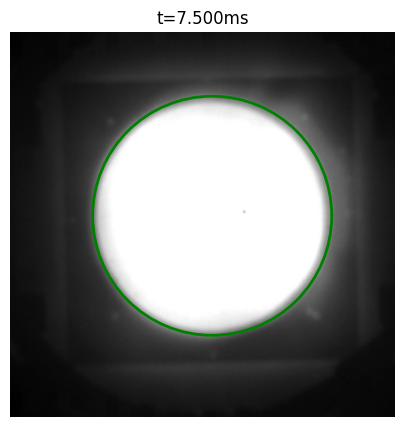

In [44]:
frame_num = 550

cap = cv2.VideoCapture(avi_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
ret, frame = cap.read()
if not ret:
    raise ValueError(f"Could not read frame")

# Detect chamber
(cx, cy), chamber_radius = detect_chamber(frame)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Display the original frame
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Draw the chamber as a circle
chamber_circle = plt.Circle((cx, cy), chamber_radius, fill=False, color='green', linewidth=2)
plt.gca().add_patch(chamber_circle)

plt.title(f"t={tarr[frame_num] * 1e3:.3f}ms")
plt.axis('off')

cap.release()

print(tarr[frame_num])

In [ ]:
v = 9.8*np.sqrt(2*1/9.8) # velocity at center of chamber in m/s

t1 = 0.027 - tarr[cf]
t2 = 0.037 - tarr[cf]
print(t1)
print(t2)

x1 = v*t1 + 0.5*9.8*t1**2
x2 = v*t2 + 0.5*9.8*t2**2

print(x1)
print(x2)

In [4]:
tr_ifn = r"E:\good_data\kapton\He3kA_B380G800G_pl0t20_uw15t35\tracking_results.npy"
show_tracking_results(tr_ifn)

Found 36 entries in tracking results

File: Y20241115_kapton_P30_16deg_x36_y0@100_030.cine
  Frame: 508
  Time: 0.005400s

File: Y20241115_kapton_P30_16deg_x36_y0@30_031.cine
  Frame: 540
  Time: 0.002000s

File: Y20241115_kapton_P30_16deg_x36_y0@480_032.cine
  Frame: 638
  Time: 0.031900s

File: Y20241115_kapton_P30_16deg_x36_y0@-220_033.cine
  Frame: 384
  Time: -0.010800s

File: Y20241115_kapton_P30_16deg_x36_y0@550_034.cine
  Frame: 543
  Time: 0.027150s

File: Y20241115_kapton_P30_16deg_x36_y0@-220_035.cine
  Frame: 340
  Time: -0.013000s

File: Y20241115_kapton_P30_16deg_x36_y0@-200_036.cine
  Frame: 410
  Time: -0.009500s

File: Y20241115_kapton_P30_16deg_x36_y0@50_037.cine
  Frame: 568
  Time: 0.003400s

File: Y20241115_kapton_P30_16deg_x36_y0@-10_038.cine
  Frame: 496
  Time: -0.000200s

File: Y20241115_kapton_P30_16deg_x36_y0@200_039.cine
  Frame: 611
  Time: 0.010550s

File: Y20241115_kapton_P30_16deg_x36_y0@250_060.cine
  Frame: 571
  Time: 0.013550s

File: Y20241115_kapton

In [45]:
update_tracking_result(tr_ifn, cine_path, cf_new=frame_num, ct_new=tarr[frame_num])

Loaded existing tracking results with 36 entries

Current values for Y20241115_kapton_P30_16deg_x36_y0@150_065.cine:
  Frame: 994
  Time: 0.029700s

Updated values:
  Frame: 550
  Time: 0.007500s
